In [2]:
%matplotlib inline
from __future__ import division
import numpy as np

import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import djPyi2 as DJ
import pandas as pd
pd.options.mode.chained_assignment = None
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import networkx as nx
from djPyi2 import mpltools
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import matplotlib.patches as patches
from djPyi2 import Common as CM
import matplotlib.image as mpimg

import numpy as np
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter
import matplotlib.patches as mpatch
import matplotlib.transforms as mtransforms

In [3]:
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles

In [4]:
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick

In [5]:
dy_name = 'Figures'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    cpy.makedir(private_out)

In [6]:
def fix_svlen(info_all):
    
    info_all = info_all.copy()
    info_all['SVLEN_MOD'] = info_all.SVLEN
    inds = info_all[info_all.SVTYPE_NR == 'STR'].index.tolist()
    info_all.loc[inds, 'SVLEN_MOD'] = info_all.loc[inds, 'MAX_ALLELE_CHANGE']
    info_all['log10_SVLEN_MOD'] = info_all['SVLEN_MOD'] 
    inds = info_all[(info_all.is_SVLEN == True) | (info_all.SVTYPE == 'INV')].index.tolist()
    info_all.loc[inds, 'log10_SVLEN_MOD'] = np.log10(info_all.loc[inds, 'SVLEN_MOD'].astype(float))
    return info_all

In [11]:
info_pass_final = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/info_pass_final_nr_per_caller.pkl')
info_nr = info_pass_final[info_pass_final.ID == info_pass_final.NR_ID]

info_pass_final_nr_per_caller = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/info_pass_final_nr_per_caller.pkl')
info_pass_final_nr_per_caller = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/info_pass_final_nr_per_caller.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/load_pickled_nb_variables.py


In [343]:
order_var = ['DEL', 'DUP', 'mCNV', 'INV', 'rMEI', 'ALU', 'LINE1', 'SVA', 'STR']

order_vars_all = ['DEL', 'DUP', 'mCNV', 'INV', 'BND','rMEI', 'ALU', 'LINE1', 'SVA', 'STR', 'INDEL DEL', 
              'INDEL INS', 'SNV']

order_sv_str = order_vars_all[:-3]

# Palettes

In [28]:
color_pal_svtypes_all = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/color_pal_svtypes_all.pkl').to_dict()

In [65]:
pallete_variant_callers = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/pallete_variant_callers.pkl').to_dict()

# Figure

# Supplementary Figures Length / Allele Frequency

In [53]:
mpl.gridspec.rcParams['legend.handletextpad'] = 0.3
mpl.gridspec.rcParams['legend.columnspacing'] = 0.5
mpl.gridspec.rcParams['legend.labelspacing'] = 0.5
mpl.gridspec.rcParams['axes.labelpad'] = 2
mpl.gridspec.rcParams['axes.titlesize'] = 7
mpl.gridspec.rcParams['axes.labelsize'] = 7
mpl.gridspec.rcParams['ytick.labelsize'] = 6
mpl.gridspec.rcParams['xtick.labelsize'] = 6
mpl.gridspec.rcParams['axes.labelweight'] = 'bold'

In [726]:
order_callers = [['GS', 'GS_LCNV', 'SS'], ['GS', 'GS_LCNV', 'SS'], ['GS', 'GS_LCNV'], 
                 ['SS'], ['MELT'], ['MELT'], ['MELT'], ['HipSTR']]
order_cnvs = ['DEL','DUP', 'mCNV']
order_vc_leg = ['SS', 'GS', 'GS_LCNV', 'MELT', 'HipSTR']

In [570]:
def fix_log_to_scalar_formatting(ax, axis = 'y'):
    
    formatter = mpl.ticker.ScalarFormatter()
    
    if axis in ['y', 'both']:
        
        ax.get_yaxis().set_major_formatter(formatter)
        ax.yaxis.get_major_formatter().set_scientific(False)
        ax.yaxis.get_minor_ticks()
        #             a.yaxis.get_major_formatter().set_useOffset(False)
        ax.get_yaxis().set_minor_formatter(formatter)
        ax.yaxis.get_minor_formatter().set_scientific(False)
    
    if axis in ['x', 'both']:
        ax.get_xaxis().set_major_formatter(formatter)
        ax.xaxis.get_major_formatter().set_scientific(False)
        ax.xaxis.get_minor_ticks()
        ax.get_xaxis().set_minor_formatter(formatter)
        ax.xaxis.get_minor_formatter().set_scientific(False)
    
    plt.sca(ax)
    plt.minorticks_off()

In [587]:
def format_easy_read_log(x, log10 = False, rounding = 1, ints = False):
    """ input list of tick locations, output formatted ticks 
    with bp,kbpb, MB annotations - log: if the ticks
    are log scaled- what base is the log scale 
    example: log=10 for log base 10"""
    if log10:
        input_ticks = [(10**i) for i in x]
    else:
        input_ticks = x    
    out = []
    for t in input_ticks: 
        if t < 1000:
            if not ints:
                f = copy.deepcopy(t)
            else:
                f = int(t)
        
        elif t > 100000:
            if not ints:
                f = "{}M".format(round((t/1000000), rounding))
            else:
                f = "{}M".format(int(round((t/1000000), rounding)))
            
        elif t >= 1000:
            if not ints:
                f = "{}K".format(round((t/1000), rounding))
            else:
                 f = "{}K".format(int(round((t/1000), rounding)))
            
        else:
            return 'missed case'
        out.append(f)
    
    return out


In [624]:
mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0

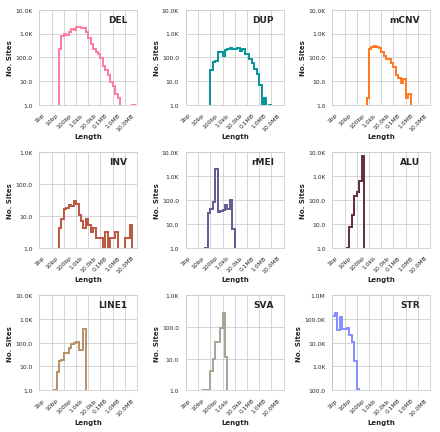

In [634]:
with sns.axes_style('whitegrid'):

    fig, axes = plt.subplots(3,3, figsize = (7,7), gridspec_kw={'wspace' : 0.5, 'hspace' :0.5})
    # gs = mpl.gridspec.GridSpec(4, 4, 
    #                            figure =fig,
    #                            width_ratios=[1, 1], height_ratios = [0.8, 1, 0.8, 0.8], wspace = 0.5, hspace=0)

    count = 0
    af = axes.flat

    # af[0].get_shared_y_axes(af[0], af[2])

    bins = np.arange(0,8, 0.2)
    for ind, svt in enumerate(order_sv_str_len):
        ax = af[ind]

        tdf = info_nr[(info_nr.SVTYPE_all == svt) & ((info_nr.is_SVLEN) | (info_nr.SVTYPE_all=='INV'))]
        ax.hist(tdf.log10_SVLEN_MOD.astype(float), bins = bins, histtype = 'step', 
                 color = color_pal_svtypes_all[svt], linewidth = 2)

        xlab = [10**i for i in np.arange(0,8)]
        xticks = [np.log10(i) for i in xlab]
        xlab_fmt = mpltools.format_base_pair_scale(xlab, mb_round=1)

        ax.set_xticks(xticks)

        ax.set_xticklabels(xlab_fmt)
        ax.tick_params(axis = 'x', labelrotation = 45)

        ylab = [10**i for i in np.arange(0,4)]
        yticks = [np.log10(i) for i in xlab]


        ax.text(0.9,0.9, svt, fontsize = 9, transform = ax.transAxes,
                    horizontalalignment='right',  verticalalignment='center', weight = 'bold')
        ax.set_yticks(yticks)

        ax.set_yscale('log')

        fix_log_to_scalar_formatting(ax)

    lim1 = af[0].get_ylim()

    for i in np.arange(1,3):
        ax = af[i]
        ax.set_ylim(lim1)

    af[3].set_ylim(af[6].get_ylim())


    for i in [5,6]:
        ax = af[i]
        ax.set_ylim(lim1)

    for ind, svt in enumerate(order_sv_str_len):
        ax = af[ind]
        ticks = ax.get_yticks()
        yticklabs = format_easy_read_log(ticks)
        ax.set_yticklabels(yticklabs)
        ax.set_xlabel('Length')
        ax.set_ylabel('No. Sites')
fig.savefig(os.path.join(private_out, 'SupFig_Length_Dist_NR_Variants'), dpi=500, bbox_inches='tight') 




In [615]:
mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0

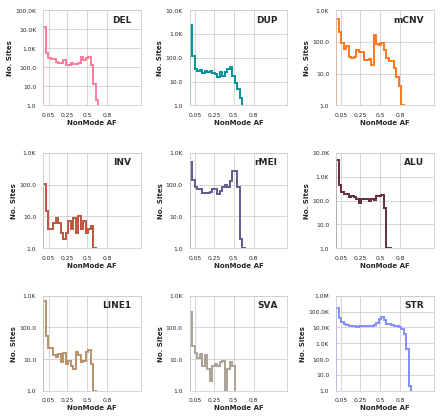

In [633]:
# fig =plt.figure(figsize=(7,7))


with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(3,3, figsize = (7,7), gridspec_kw={'wspace' : 0.5, 'hspace' :0.5}, sharex = True)
    # gs = mpl.gridspec.GridSpec(4, 4, 
    #                            figure =fig,
    #                            width_ratios=[1, 1], height_ratios = [0.8, 1, 0.8, 0.8], wspace = 0.5, hspace=0)


    count = 0
    af = axes.flat

    # af[0].get_shared_y_axes(af[0], af[2])

    bins = np.arange(0, 0.4, 0.01)
    for ind, svt in enumerate(order_sv_str_len):
        ax = af[ind]

        tdf = info_nr[(info_nr.SVTYPE_all == svt) & ((info_nr.is_SVLEN) | (info_nr.SVTYPE_all=='INV'))]
        ax.hist(np.log10(tdf.NMODE_AF_unrel.astype(float) + 1), bins = bins, histtype = 'step', 
                 color = color_pal_svtypes_all[svt], linewidth = 2)

        xlab = [0.05, 0.25, 0.5, 0.8]
        xticks = [np.log10(i + 1) for i in xlab]

        ax.set_xticks(xticks)
        ax.xaxis.set_tick_params(which = 'both', labelbottom = True)
        ax.set_xticklabels(xlab)

        ax.set_yscale('log')
        fix_log_to_scalar_formatting(ax)
        yticklabs = format_easy_read_log(ax.get_yticks())
        ax.set_yticklabels(yticklabs)
        ax.set_xlabel('NonMode AF')
        ax.set_ylabel("No. Sites")
        ax.text(0.9,0.9, svt, fontsize = 9, transform = ax.transAxes,
                horizontalalignment='right',  verticalalignment='center', weight = 'bold')

fig.savefig(os.path.join(private_out, 'SupFig_MAF_Dist_NR_Variants'), dpi=500, bbox_inches='tight') 